In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.offsetbox import AnchoredText

In [2]:
def loadFile(filename):
    fileData = np.loadtxt(filename, delimiter=',', skiprows=1, ndmin=2)
    return fileData

In [30]:
def get_latex_output(polynomial, precision=None, x_symbol='x', y_symbol='f', x_unit=None, y_unit=None):
    coefficients = polynomial.coef
    latex_output = f'{y_symbol} ({x_symbol}) = '
    for i in range(len(coefficients)).__reversed__():
        coef = f"{coefficients[i]:.{precision}g} " if precision is not None else f"{coefficients[i]}"
        if y_unit is not None:
            coef += f" {y_unit}"
        if x_unit is not None:
            coef += f" / {x_unit}^{i}"
        if i == 0:
            latex_output += f"{coef}"
        else:
            latex_output += f"{coef} {x_symbol}^{i}"
            latex_output += f" + " if coefficients[i-1] >= 0 else f" "
    return f"${latex_output}$"

In [31]:
filename = ['data/joined_data.csv']

data = None
for f in filename:
    data_f = loadFile(f)
    if data is None:
        data = data_f
    else:
        data = np.vstack((data, data_f))

data.shape

(6501, 10)

In [32]:
thrust = data[:,0] / 4  # g, per motor
pwm = data[:,1]         # PWM value
vbat = data[:,2]        # V, battery voltage, 
rpm = np.mean(data[:,3:7],axis=1) # average over all motors
m1  = data[:,3]
m2  = data[:,4]
m3  = data[:,5]
m4  = data[:,6]
vSid =  data[:, 7]      # Volts at system id deck
amp =  data[:, 8]       # Amps
pwr = data[:, 9]        # Power in watts

In [33]:
domain_pwm = [0.0, max(pwm)] 
domain_rpm = [0.0, max(rpm)] 
domain_thrust = [0.0, max(thrust)] 

In [34]:
# pwm2rpm.py
p_pwm2rpm = np.polynomial.Polynomial.fit(pwm, rpm, deg=[2,1], domain=domain_pwm, window=domain_rpm).convert()

np.polynomial.set_default_printstyle('ascii')
print(p_pwm2rpm.coef, p_pwm2rpm.domain, p_pwm2rpm.window)
print(get_latex_output(p_pwm2rpm, x_symbol='PWM', y_symbol='RPM', precision=4, y_unit='1/min'))
# p_con = p.convert()
# print(p_con)
# print(p_con.coef, p_con.domain, p_con.window)

eval_pwm2rpm = p_pwm2rpm(pwm)
p_pwm2rpm(0.0)

[ 0.00000000e+00  4.94028767e-01 -2.65019222e-06] [-1.  1.] [-1.  1.]
$RPM (PWM) = -2.65e-06  1/min PWM^2 + 0.494  1/min PWM^1 + 0  1/min$


np.float64(0.0)

In [35]:
# pwm2thrust
p_pwm2thrust = np.polynomial.Polynomial.fit(pwm, thrust, deg=[3,2,1], domain=domain_pwm, window=domain_thrust).convert()

print(p_pwm2thrust.coef, p_pwm2thrust.domain, p_pwm2thrust.window)
print(get_latex_output(p_pwm2thrust, x_symbol='PWM', y_symbol='Thrust', precision=4, y_unit='g'))

eval_pwm2thrust = p_pwm2thrust(pwm)
p_pwm2thrust(0.0)

[ 0.00000000e+00 -2.27189321e-05  1.10611467e-08 -9.53297571e-14] [-1.  1.] [-1.  1.]
$Thrust (PWM) = -9.533e-14  g PWM^3 + 1.106e-08  g PWM^2 -2.272e-05  g PWM^1 + 0  g$


np.float64(0.0)

In [36]:
# pwm2thrust linear
p_pwm2thrust_linear = np.polynomial.Polynomial.fit(pwm, thrust, deg=[1], domain=domain_pwm, window=domain_thrust).convert()

print(p_pwm2thrust.coef, p_pwm2thrust.domain, p_pwm2thrust.window)
print(get_latex_output(p_pwm2thrust, x_symbol='PWM', y_symbol='Thrust', precision=4, y_unit='g'))

eval_pwm2thrust_linear = p_pwm2thrust_linear(pwm)
p_pwm2thrust_linear(0.0)

[ 0.00000000e+00 -2.27189321e-05  1.10611467e-08 -9.53297571e-14] [-1.  1.] [-1.  1.]
$Thrust (PWM) = -9.533e-14  g PWM^3 + 1.106e-08  g PWM^2 -2.272e-05  g PWM^1 + 0  g$


np.float64(0.0)

In [37]:
# rpm2thrust
p_rpm2thrust = np.polynomial.Polynomial.fit(rpm, thrust, deg=[2], domain=domain_rpm, window=domain_thrust).convert()

print(p_rpm2thrust.coef, p_rpm2thrust.domain, p_rpm2thrust.window)
print(get_latex_output(p_rpm2thrust, x_symbol='RPM', y_symbol='Thrust', precision=4, x_unit='1/min', y_unit='g'))

eval_rpm2thrust = p_rpm2thrust(rpm)
p_rpm2thrust(0.0)

[0.00000000e+00 0.00000000e+00 4.41064445e-08] [-1.  1.] [-1.  1.]
$Thrust (RPM) = 4.411e-08  g / 1/min^2 RPM^2 + 0  g / 1/min^1 RPM^1 + 0  g / 1/min^0$


np.float64(0.0)

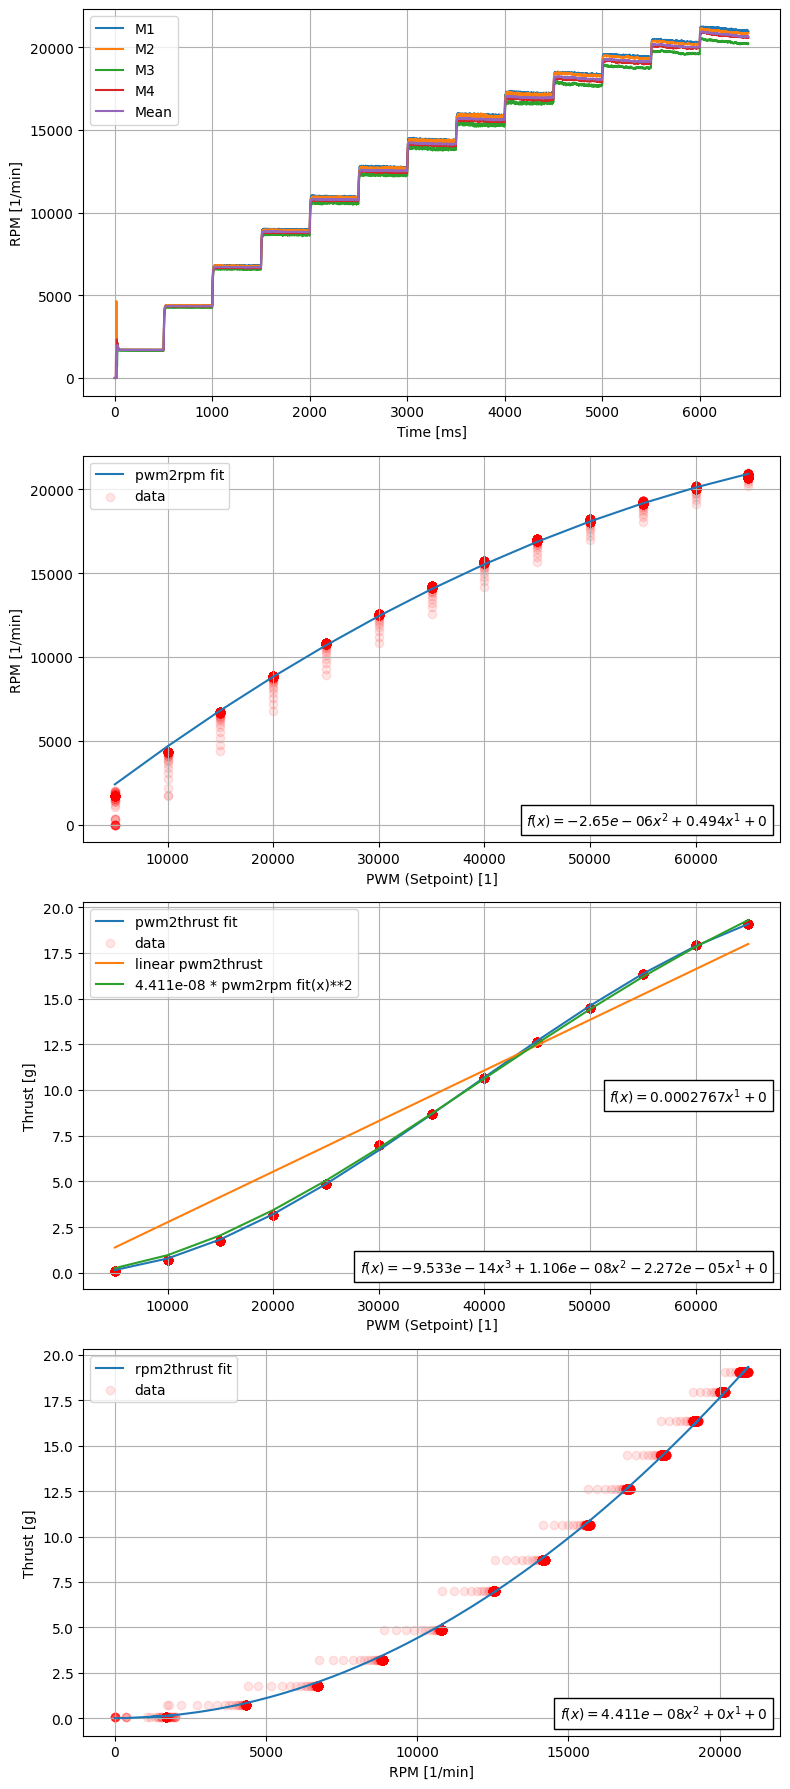

In [ ]:
fig, ax = plt.subplots(4, figsize=(8,18))
ax[0].plot(m1, label='M1')
ax[0].plot(m2, label='M2')
ax[0].plot(m3, label='M3')
ax[0].plot(m4, label='M4')
ax[0].plot(rpm, label='Mean')

ax[0].set_xlabel('Time [ms]')
ax[0].set_ylabel('RPM [1/min]')
ax[0].legend()
ax[0].grid(True)


# pwm2rpm
ax[1].plot(pwm, eval_pwm2rpm, label='pwm2rpm fit')
ax[1].scatter(pwm, rpm, label='data', alpha=0.1, color='red')
ax[1].set_xlabel('PWM (Setpoint) [1]')
ax[1].set_ylabel('RPM [1/min]')
ax[1].legend()
ax[1].grid(True)

ax[1].add_artist(AnchoredText(get_latex_output(p_pwm2rpm, precision=4), loc=4))


# pwm2thrust
k = p_rpm2thrust.coef[2]
ax[2].plot(pwm, eval_pwm2thrust, label='pwm2thrust fit')
ax[2].scatter(pwm, thrust, label='data', alpha=0.1, color='red')
ax[2].plot(pwm, k*eval_pwm2rpm**2, label=f'{k:.4g} * pwm2rpm fit(x)**2')
ax[2].plot(pwm, eval_pwm2thrust_linear, label=f'linear pwm2thrust')

ax[2].set_xlabel('PWM (Setpoint) [1]')
ax[2].set_ylabel('Thrust [g]')
ax[2].legend()
ax[2].grid(True)

ax[2].add_artist(AnchoredText(get_latex_output(p_pwm2thrust, precision=4), loc=4))
ax[2].add_artist(AnchoredText(get_latex_output(p_pwm2thrust_linear, precision=4), loc=7))

# rpm2thrust
ax[3].plot(rpm, eval_rpm2thrust, label='rpm2thrust fit')
ax[3].scatter(rpm, thrust, label='data', alpha=0.1, color='red')
ax[3].set_xlabel('RPM [1/min]')
ax[3].set_ylabel('Thrust [g]')
ax[3].legend()
ax[3].grid(True)

ax[3].add_artist(AnchoredText(get_latex_output(p_rpm2thrust, precision=4), loc=4))



plt.tight_layout()
plt.savefig('fit.png', dpi=400)